# PyTorch を利用した実装

In [30]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

### パラメータの定義

In [31]:
epoch_num = 20  # エポック数を設定する
batch_size = 100  # バッチの数
learning_rate = 0.1  # 学習係数

### MNIST データセット

In [32]:
# 訓練データをdatasetsからダウンロード
training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

# テストデータをdatasetsからダウンロード
test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

### データローダー

In [33]:
# データローダーの作成
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print("X.shape [N, C, H, W]:", X.shape)
    print("y.shape:", y.shape, y.dtype)
    break

X.shape [N, C, H, W]: torch.Size([100, 1, 28, 28])
y.shape: torch.Size([100]) torch.int64


#### 【オプション】入力データの確認

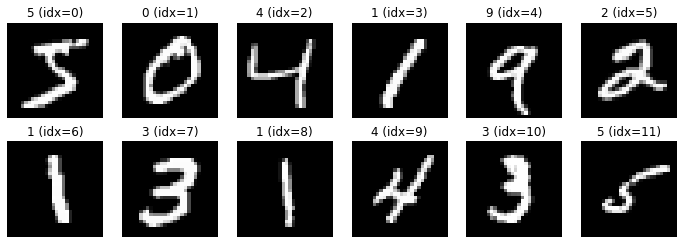

tensor([5, 0, 4, 1, 9, 2, 1, 3, 1, 4, 3, 5])


In [34]:
for X, y in train_dataloader:
    x_train = X
    t_train = y
    break

# 画像を表示
figure = plt.figure(figsize=(12, 4))
rows, cols = 2, 6
for i in range(rows * cols):
    img, label = x_train[i], t_train[i]
    figure.add_subplot(rows, cols, i + 1)
    plt.title(f'{label} (idx={i})')
    plt.axis('off')
    plt.imshow(img.squeeze(), cmap='gray')  # 1x28x28 -> 28x28 に変換
plt.show()
print(y[:rows * cols])

### ニューラルネットワークの定義

In [35]:
# modelを定義します
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_sigmoid_stack = nn.Sequential(
            nn.Linear(28*28, 50),
            #nn.Sigmoid(),
            nn.ReLU(),
            nn.Linear(50, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_sigmoid_stack(x)
        return logits

### ニューラルネットワークのインスタンス化

In [36]:
# 訓練に際して、可能であればGPU（cuda）を設定します。GPUが搭載されていない場合はCPUを使用します
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

model = NeuralNetwork().to(device)
print(model)

Using cpu device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_sigmoid_stack): Sequential(
    (0): Linear(in_features=784, out_features=50, bias=True)
    (1): ReLU()
    (2): Linear(in_features=50, out_features=10, bias=True)
  )
)


### 損失関数と最適化手法を定義

In [37]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

### 訓練のプロセス

In [38]:
def train(dataloader, model, loss_fn, optimizer):
    model.train()  # 訓練モード
    loss_list = []
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        #y = torch.eye(10)[y]  # index -> one-hot 形式に変換
        
        # 損失誤差を計算
        pred = model(X)
        loss = loss_fn(pred, y)
        
        # バックプロパゲーション
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        loss_list.append(loss.item())
    
    return loss_list

### 評価のプロセス

In [39]:
def test(dataloader, model):
    model.eval()  # 評価モード
    correct = 0
    size = len(dataloader.dataset)
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    correct /= size
    
    return correct

### ミニバッチの学習

In [40]:
train_loss_list = []
train_acc_list = [0.0]
test_acc_list = [0.0]

for t in range(epoch_num):
    train_loss = train(train_dataloader, model, loss_fn, optimizer)
    train_loss_list += train_loss
    print(f'epoch({t + 1}) loss = {train_loss_list[-1]}')
    train_acc = test(train_dataloader, model)
    test_acc = test(test_dataloader, model)
    train_acc_list.append(train_acc)
    test_acc_list.append(test_acc)
    print(f'epoch({t + 1}) accuracy(train, test) = ({train_acc}, {test_acc})')

print('Done!')

epoch(1) loss = 0.35061293840408325
epoch(1) accuracy(train, test) = (0.9050333333333334, 0.9094)
epoch(2) loss = 0.29743894934654236
epoch(2) accuracy(train, test) = (0.9268666666666666, 0.9298)
epoch(3) loss = 0.2688058912754059
epoch(3) accuracy(train, test) = (0.9386833333333333, 0.9374)
epoch(4) loss = 0.2539989948272705
epoch(4) accuracy(train, test) = (0.9479833333333333, 0.944)
epoch(5) loss = 0.24498037993907928
epoch(5) accuracy(train, test) = (0.9552833333333334, 0.9497)
epoch(6) loss = 0.23960334062576294
epoch(6) accuracy(train, test) = (0.9603333333333334, 0.9544)
epoch(7) loss = 0.23193806409835815
epoch(7) accuracy(train, test) = (0.9640166666666666, 0.9582)
epoch(8) loss = 0.22791673243045807
epoch(8) accuracy(train, test) = (0.9671666666666666, 0.9606)
epoch(9) loss = 0.22262676060199738
epoch(9) accuracy(train, test) = (0.96985, 0.9628)
epoch(10) loss = 0.21910451352596283
epoch(10) accuracy(train, test) = (0.97145, 0.9645)
epoch(11) loss = 0.21721947193145752
epoch(

### 損失関数の推移

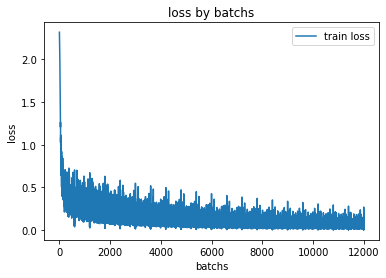

In [41]:
# グラフの描画
x = torch.arange(len(train_loss_list))
plt.plot(x, train_loss_list, label='train loss')
plt.xlabel('batchs')
plt.ylabel('loss')
plt.title('loss by batchs')
plt.legend(loc='upper right')
plt.show()

### 認識精度の推移

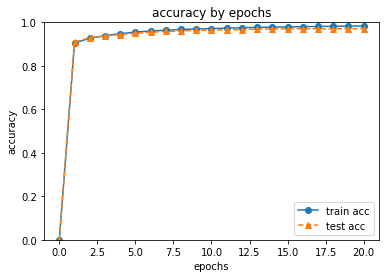

In [42]:
# グラフの描画
x = torch.arange(len(train_acc_list))
plt.plot(x, train_acc_list, label='train acc', marker='o')
plt.plot(x, test_acc_list, label='test acc', linestyle='--', marker='^')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('accuracy by epochs')
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

#### 【オプション】テストの結果

In [43]:
x_test = None
t_test = None
test_predict = None

# テストの実行
model.eval()
for batch, (X, y) in enumerate(test_dataloader):
    with torch.no_grad():
        pred = model(X)
        x_test = torch.cat((x_test,X),0) if x_test is not None else X
        t_test = torch.cat((t_test,y),0) if t_test is not None else y
        test_predict = torch.cat((test_predict,pred),0) if test_predict is not None else pred

print(test_predict.shape)
for index in range(3):
    print(f'index = {index}')
    print(test_predict[index])
    print(t_test[index])

torch.Size([10000, 10])
index = 0
tensor([  0.6088,  -4.3959,   5.9133,   6.1510,  -4.8688,  -2.1265, -15.6472,
         14.1798,  -2.5260,   1.9641])
tensor(7)
index = 1
tensor([ -0.4570,   5.1100,  15.1153,   8.4950, -12.2529,   3.8457,   1.9629,
         -9.7362,   2.7925, -10.7149])
tensor(2)
index = 2
tensor([-4.0131,  8.0581,  1.0457, -1.2704, -0.0903,  0.6838, -1.5005,  1.2144,
         1.6584, -3.3626])
tensor(1)


#### 【オプション】エラー結果の確認

error rate = 2.92[%] (num = 292/10000)


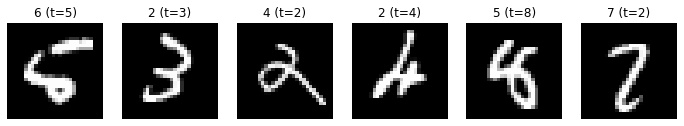

tensor([[ -0.4096,  -5.7916,   2.2272,  -4.4653,  -0.3189,   3.3207,   5.7749,
          -5.1660,   2.8112,   0.1960],
        [ -1.6003,   0.9700,   9.4405,   9.3827,  -9.6496,  -1.9021,  -5.6061,
          -1.1805,   4.6456,   2.0353],
        [ -3.5795,  -0.6464,   3.4722,   0.0625,   4.3796,   0.3522,  -1.4543,
          -2.9643,  -0.8380,   2.6317],
        [ -1.0700,  -0.9030,   8.9391,  -1.5026,   3.9646,  -0.2588,   7.8433,
          -0.4630,  -3.1335,  -9.9440],
        [ -9.2030,  -1.9972,  -8.1013,   0.7423,   6.6388,   6.9861,  -2.6196,
          -7.8144,   6.0306,   4.8257],
        [ -3.7994,   1.4512,   6.3470,   5.6205,  -8.1647,   1.5813, -13.9771,
           9.1327,   3.2498,   1.0674]])


In [44]:
# エラー結果の要素を抽出
index_error = torch.argmax(test_predict, axis=1) != t_test
error_list = torch.arange(len(test_predict))[index_error]
print(f'error rate = {len(error_list) / len(test_predict) * 100}[%]',
      f'(num = {len(error_list)}/{len(test_predict)})')

offset = 0
# 画像を表示
figure = plt.figure(figsize=(12, 2))
rows, cols = 1, 6
for i in range(rows * cols):
    index = error_list[offset + i]
    img, label_t, label_y = x_test[index], t_test[index], test_predict[index].argmax()
    figure.add_subplot(rows, cols, i + 1)
    plt.title(f'{label_y} (t={label_t})')
    plt.axis('off')
    plt.imshow(img.squeeze(), cmap='gray')  # 1x28x28 -> 28x28 に変換
plt.show()
print(test_predict[error_list[offset:offset + rows * cols]])